## 正侧视CSA点目标成像

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体 
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题 

from numpy import pi,abs,max,min,argmax,argmin,ceil,exp,sqrt,real,imag,conj,sinc,sin,cos,tan,arctan,log10,angle,unwrap
from numpy import linspace,arange,zeros,ones,concatenate,convolve
from numpy.fft import fft,fftshift,ifft,ifftshift,fft2
from matplotlib.pyplot import figure,subplot,plot,axis,title,suptitle,xlabel,ylabel,text,arrow,tight_layout

In [4]:
def output_txt(txt,array):
    (m,n) = array.shape
    fw=open(txt, 'wt')
    for i in range(m):
        for j in range(n):
            r = array[i,j]
            ra = r.real
            ri = r.imag
            if( ra>=0 ):
                fw.write('+')
            fw.write("%14.8e"%(ra))
            if( ri>=0 ):
                fw.write('+')
            fw.write("%14.8ej"%(ri))
            if( j==n-1):
                fw.write('\n')
            else:
                fw.write(' ')
    fw.close()

In [5]:
######################################
#               正侧视
#                RDA
#              点目标仿真
######################################

# --------------------------------------------------------------------
# 定义参数
# --------------------------------------------------------------------
R_nc = 20e3;            # 景中心斜距
Vr = 150;               # 雷达有效速度
Tr = 2.5e-6;            # 发射脉冲时宽
Kr = 20e12;             # 距离调频率
f0 = 5.3e9;             # 雷达工作频率
BW_dop = 80;            # 多普勒带宽
Fr = 60e6;              # 距离采样率
Fa = 200;               # 方位采样率
Naz = 1024;          	# 距离线数（即数据矩阵，行数）——这里修改为1024。
Nrg = 320;              # 距离线采样点数（即数据矩阵，列数）
sita_r_c = (0*pi)/180;	# 波束斜视角，0 度，这里转换为弧度
c = 3e8;                # 光速

R0 = R_nc*cos(sita_r_c);	# 与R_nc相对应的最近斜距，记为R0
Nr = int(ceil(Tr*Fr));             # 线性调频信号采样点数
BW_range = Kr*Tr;       # 距离向带宽
lamda0 = c/f0;           # 波长
fnc = 2*Vr*sin(sita_r_c)/lamda0;     # 多普勒中心频率，根据公式（4.33）计算。
La_real = 0.886*2*Vr*cos(sita_r_c)/BW_dop; # 方位向天线长度，根据公式（4.36）
beta_bw = 0.886*lamda0/La_real;           # 雷达3dB波束
La = beta_bw*R0;        # 合成孔径长度
a_sr = Fr / BW_range;   # 距离向过采样因子
a_sa = Fa / BW_dop;     # 方位向过采样因子

Mamb = round(fnc/Fa);   # 多普勒模糊

NFFT_r = Nrg;           # 距离向FFT长度
NFFT_a = Naz;           # 方位向FFT长度

R_ref = R0;             # 参考目标选在场景中心，其最近斜距为 R_ref
fn_ref = fnc;        	# 参考目标的多普勒中心频率

# --------------------------------------------------------------------
# 设定仿真点目标的位置
# 以距离向作为x轴正方向
# 以方位向作为y轴正方向
# -------------------------------------------------------------------- 
delta_R0 = 0;       # 将目标1的波束中心穿越时刻，定义为方位向时间零点。
delta_R1 = 120; 	# 目标1和目标2的方位向距离差，120m
delta_R2 = 50;      # 目标2和目标3的距离向距离差，50m

# 目标1
x1 = R0;            # 目标1的距离向距离
y1 = delta_R0 + x1*tan(sita_r_c);	# 目标1的方位向距离

# 目标2
x2 = x1;            # 目标2和目标1的距离向距离相同
y2 = y1 + delta_R1; # 目标2的方位向距离
# 目标3
x3 = x2 + delta_R2;                 # 目标3和目标2有距离向的距离差，为delta_R2
y3 = y2 + delta_R2*tan(sita_r_c);  	# 目标3的方位向距离
# 定义以下数组，便于处理
x_range = np.array([x1,x2,x3]);
y_azimuth = np.array([y1,y2,y3]);

# 计算三个目标各自的波束中心穿越时刻
nc_1 = (y1-x1*tan(sita_r_c))/Vr;    # 目标1的波束中心穿越时刻。
nc_2 = (y2-x2*tan(sita_r_c))/Vr;    # 目标2的波束中心穿越时刻。
nc_3 = (y3-x3*tan(sita_r_c))/Vr;    # 目标3的波束中心穿越时刻。
nc_target = np.array([nc_1,nc_2,nc_3]);       # 定义该数组，便于处理。

In [6]:
## 
# --------------------------------------------------------------------
# 距离（方位）向时间，频率相关定义
# --------------------------------------------------------------------
# 距离
tr = 2*R0/c + arange( -Nrg/2,Nrg/2,1 )/Fr;                # 距离时间轴
fr = arange( -NFFT_r/2 , NFFT_r/2,1 )*( Fr/NFFT_r );          # 距离频率轴
# 方位
ta = arange( -Naz/2, Naz/2,1 )/Fa;                            # 方位时间轴
fa = fnc + fftshift(arange( -NFFT_a/2 ,NFFT_a/2,1 ))*( Fa/NFFT_a );	# 方位频率轴

# 生成距离（方位）时间（频率）矩阵
tr_mtx = ones((Naz,1))*tr.reshape((1,Nrg));    # 距离时间轴矩阵，大小：Naz*Nrg
ta_mtx = ta.reshape((Naz,1))*ones((1,Nrg));  # 方位时间轴矩阵，大小：Naz*Nrg
fr_mtx = ones((Naz,1))*fr.reshape((1,Nrg));    # 距离频率轴矩阵，大小：Naz*Nrg
fa_mtx = fa.reshape((Naz,1))*ones((1,Nrg));  # 方位频率轴矩阵，大小：Naz*Nrg

## 
# --------------------------------------------------------------------
# 生成点目标原始数据
# --------------------------------------------------------------------
s_echo = zeros((Naz,Nrg),dtype="complex");    # 用来存放生成的回波数据

A0 = 1;                     # 目标回波幅度，都设置为1.
for k in range(3):                 # 生成k个目标的原始回波数据
    R_n = sqrt( (x_range[k]*ones((Naz,Nrg)))**2 + (Vr*ta_mtx-y_azimuth[k]*ones((Naz,Nrg)))**2 );# 目标k的瞬时斜距
    w_range = np.where(abs(tr_mtx-2*R_n/c) <= Tr/2,1,0)     # 距离向包络，即距离窗
    # =====================================================================    
    # 方位向包络，也就是 天线的双程方向图作用因子。
    #{
    # 方式1
    # sinc平方型函数，根据公式（4.31）计算    
    #sita = arctan( Vr*(ta_mtx-nc_target[k]*ones((Naz,Nrg)))/x_range[k] );
    #w_azimuth = (sinc(0.886*sita/beta_bw))**2;    
    # 用每个目标对应的 波束中心穿越时刻，而不是之前参数中的nc。
    #}
    #
    # 方式2
    # 利用合成孔径长度，直接构造矩形窗（其实这里只是限制数据范围，没有真正加窗）
    w_azimuth = np.where(abs(ta - nc_target[k]) <= (La/2)/Vr,1,0);    # 行向量
    w_azimuth = w_azimuth.reshape((Naz,1))*ones((1,Nrg));    # 生成Naz*Nrg的矩阵
    #}
    # =====================================================================     
    s_k = A0*w_range*w_azimuth*exp(-(1j*4*pi*f0)*R_n/c)*exp((1j*pi*Kr)*(tr_mtx-2*R_n/c)**2);
    # 上式就是生成的某一个点目标（目标k）的回波信号。
    # 经过几次循环，生成几个点目标的回波信号，相加即可。
    if k == 0:
        s_1 = s_k;          # 目标1的回波信号

    if k == 1:  
        s_2 = s_k;          # 目标2的回波信号

    if k == 2:
        s_3 = s_k;          # 目标3的回波信号

    s_echo = s_echo + s_k;  # 所有点目标回波信号之和   

In [7]:
output_txt('c:/s_echo.txt',s_echo)

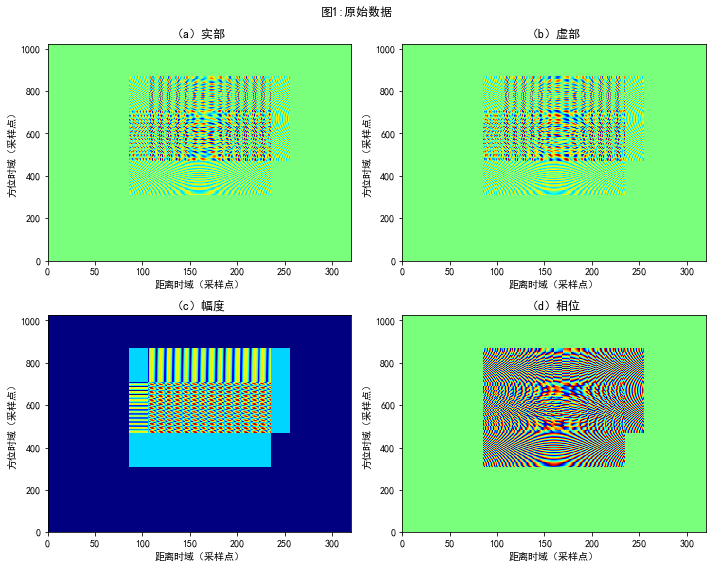

In [8]:

# s_echo 就是我们需要的原始数据，点目标回波信号。

# 作图
# 图1——原始数据
figure(figsize=(10,8));
subplot(2,2,1);
plt.pcolor(real(s_echo),cmap='jet');
title('（a）实部');
xlabel('距离时域（采样点）');
ylabel('方位时域（采样点）');
suptitle('图1:原始数据');       # 给图1进行文字说明 
# text 函数：在图像的指定坐标位置，添加文本框

subplot(2,2,2);
plt.pcolor(imag(s_echo),cmap='jet');
title('（b）虚部');
xlabel('距离时域（采样点）');
ylabel('方位时域（采样点）');

subplot(2,2,3);
plt.pcolor(abs(s_echo),cmap='jet');
title('（c）幅度');
xlabel('距离时域（采样点）');
ylabel('方位时域（采样点）');

subplot(2,2,4);
plt.pcolor(angle(s_echo),cmap='jet');
title('（d）相位');
xlabel('距离时域（采样点）');
ylabel('方位时域（采样点）');
plt.tight_layout()

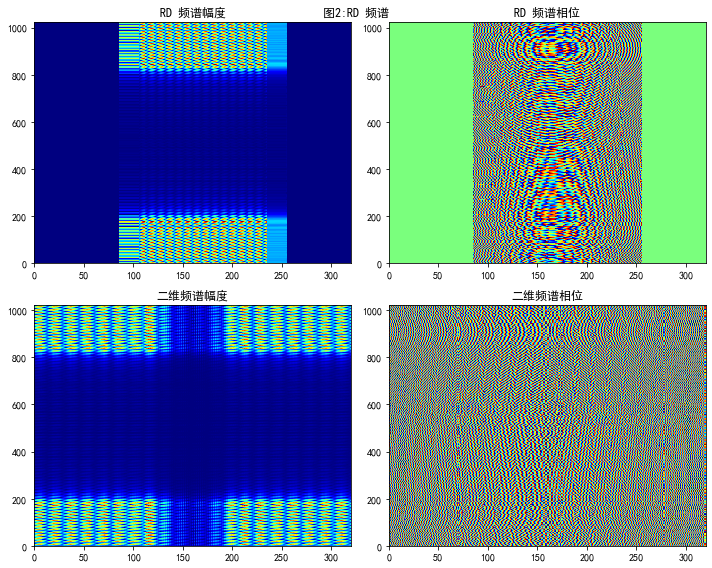

In [9]:
# 图2
figure(figsize=(10,8));
subplot(2,2,1);
plt.pcolor(abs(fft(s_echo,axis=0)),cmap='jet');
title('RD 频谱幅度');
subplot(2,2,2);
plt.pcolor(angle(fft(s_echo,axis=0)),cmap='jet');
title('RD 频谱相位');
subplot(2,2,3);
plt.pcolor(abs(fft2(s_echo)),cmap='jet');
title('二维频谱幅度');
subplot(2,2,4);
plt.pcolor(angle(fft2(s_echo)),cmap='jet');
title('二维频谱相位');
plt.tight_layout()
suptitle('图2:RD 频谱');  

In [44]:
# --------------------------------------------------------------------
# 变换到距离多普勒域，进行“补余RCMC”
# --------------------------------------------------------------------
s_rd = s_echo*exp(-1j*2*pi*fnc*(np.matmul(ta.reshape((Naz,1)),ones((1,Nrg))))); 	# 数据搬移
S_RD = fft(s_rd,NFFT_a,axis=0);  # 进行方位向傅里叶变换，得到距离多普勒域频谱

D_fn_Vr = sqrt(1-lamda0**2*fa**2/(4*Vr**2));     # 徙动因子，列向量
D_fn_Vr_mtx = np.matmul(D_fn_Vr.reshape((Naz,1)),ones((1,Nrg)));  # 形成矩阵，大小：Nrg*Naz

D_fn_ref_Vr = sqrt(1-lamda0**2*fn_ref**2/(4*Vr**2));    # 参考频率fn_ref处的徙动因子，是常数。

K_src = 2*Vr**2*f0**3*D_fn_Vr**3/(c*R_ref*(fa)**2);   # 列向量，使用R_ref处的值 

K_src_mtx = np.matmul(K_src.reshape((Naz,1)),ones((1,Nrg)));  # 形成矩阵
# print(K_src_mtx)
Km = Kr/(1-Kr/K_src_mtx);     # 矩阵，这是变换到距离多普勒域的距离调频率。
                                # 使用 R_ref 处的值

d:\anaconda3\envs\stock\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


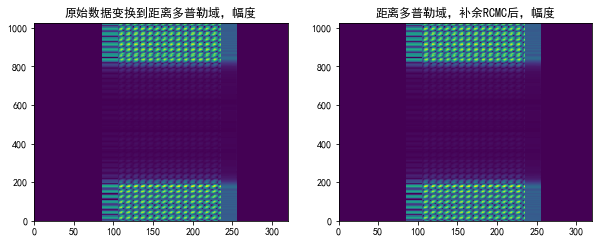

In [45]:
# 下面生成 变标方程 s_sc
s_sc = exp(1j*pi*Km*(D_fn_ref_Vr/D_fn_Vr_mtx-1)*(tr_mtx-2*R_ref/(c*D_fn_Vr_mtx))**2);
# 下面将距离多普勒域的信号与变标方程相乘，实现“补余RCMC”
S_RD_1 = S_RD*s_sc;        # 相位相乘，实现“补余RCMC”
output_txt('c:/S_RD_1.txt',S_RD_1)
# 作图
figure(figsize=(10,8));
subplot(2,2,1);
plt.pcolor(abs(S_RD));
title('原始数据变换到距离多普勒域，幅度');
subplot(2,2,2);
plt.pcolor(abs(S_RD_1));
title('距离多普勒域，补余RCMC后，幅度');

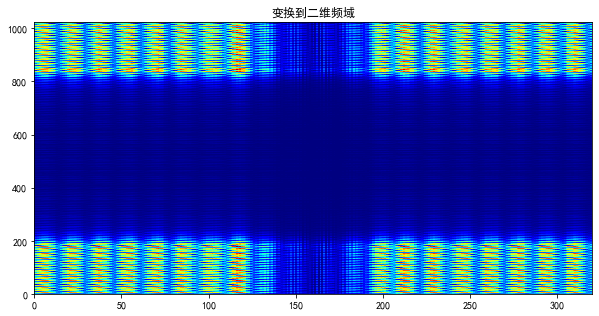

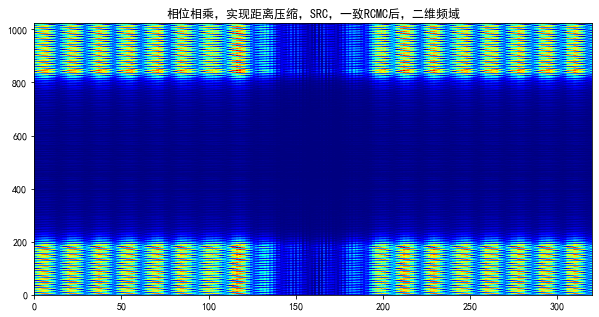

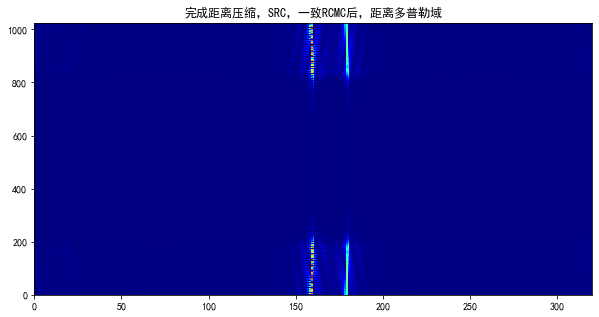

In [46]:
## 
# --------------------------------------------------------------------
# 变换到二维频域，进行“距离压缩，SRC，一致RCMC”
# --------------------------------------------------------------------
S_2df_1 = fft(S_RD_1,NFFT_r,axis=1);         # 进行距离向FFT，变换到二维频域。距离零频在两端
output_txt('c:/S_2df_1.txt',S_2df_1)
# 完成距离压缩，SRC，一致RCMC这三者相位补偿的滤波器为：
H1 = exp(1j*pi*D_fn_Vr_mtx/(D_fn_ref_Vr*Km)*fr_mtx**2)*exp(1j*4*pi/c*(1/D_fn_Vr_mtx-1/D_fn_ref_Vr)*R_ref*fr_mtx);
output_txt('c:/H1.txt',H1)
# 上面的H1距离零频在中心axis=0
window_1 = np.kaiser(Nrg,3); 
W_ref = np.matmul(ones((Naz,1)),window_1.reshape((1,Nrg)));	# 距离向，构建Kaiser窗，此为矩阵形式，距离零频在中心。
# H1 = W_ref.*H1;             # 加入距离平滑窗，以抑制旁瓣，距离零频在中心。
# 下面通过fftshift将H1的距离零频调整到两端
H1 = fftshift(H1);        # 左右半边互换，距离零频在两端。

S_2df_2 = S_2df_1*H1;    	# 在二维频域，相位相乘，实现距离压缩，SRC，一致RCMC

S_RD_2 = ifft(S_2df_2,NFFT_r,axis=1);    # 进行距离IFFT，回到距离多普勒域，完成所有距离处理。
output_txt('c:/S_RD_2.txt',S_RD_2)
# 作图
# 作图
figure(figsize=(10,5));
plt.pcolor(abs(S_2df_1),cmap='jet');
title('变换到二维频域');

figure(figsize=(10,5));
plt.pcolor(abs(S_2df_2),cmap='jet');
title('相位相乘，实现距离压缩，SRC，一致RCMC后，二维频域');

figure(figsize=(10,5));
plt.pcolor(abs(S_RD_2),cmap='jet');
title('完成距离压缩，SRC，一致RCMC后，距离多普勒域');


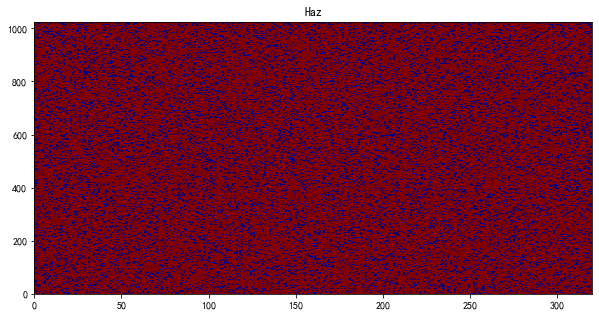

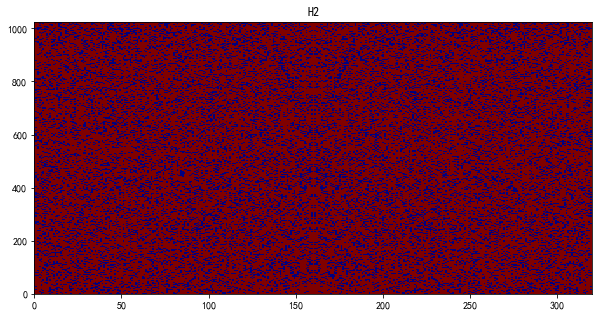

In [47]:
##
# --------------------------------------------------------------------
# 距离多普勒域，完成“方位压缩”和“附加相位校正”
# --------------------------------------------------------------------
R0_RCMC = (c/2)*tr;   # 随距离线变化的R0，记为R0_RCMC，用来计算方位MF。

# 生成方位向匹配滤波器
Haz = exp(1j*4*pi*(D_fn_Vr.reshape((Naz,1))*R0_RCMC.reshape(1,Nrg))*f0/c);       # 方位MF

# 附加相位校正项
H2 = exp(-1j*4*pi*Km/(c**2)*(1-D_fn_Vr_mtx/D_fn_ref_Vr)*((1/D_fn_Vr).reshape((Naz,1))*R0_RCMC.reshape((1,Nrg))-R_ref/D_fn_Vr_mtx)**2); 	# 附加相位校正项

figure(figsize=(10,5));
plt.pcolor(abs(Haz),cmap='jet');
title('Haz');

figure(figsize=(10,5));
plt.pcolor(abs(H2),cmap='jet');
title('H2');

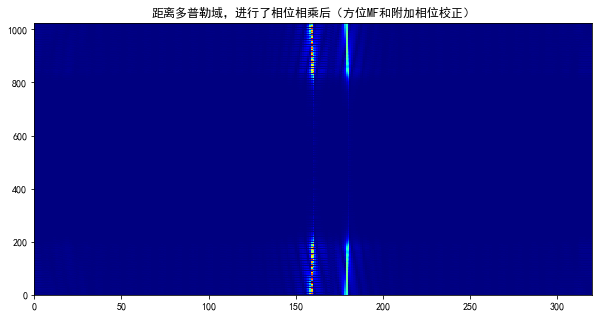

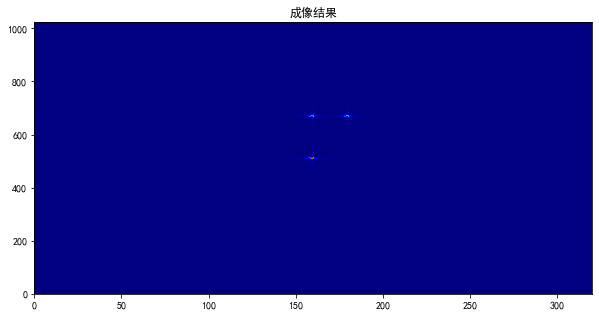

In [48]:
# 下面进行相位相乘，在距离多普勒域，同时完成方位MF和附加相位校正
S_RD_3 = S_RD_2*Haz*H2;           # 距离多普勒域，相位相乘
output_txt('c:/S_RD_3.txt',S_RD_3)
# 最后通过IFFT回到图像域，完成方位处理
s_image = ifft(S_RD_3,NFFT_a,axis=0); 	# 完成成像过程，得到成像结果为：s_image
# 作图
figure(figsize=(10,5));
plt.pcolor(abs(S_RD_3),cmap='jet');
title('距离多普勒域，进行了相位相乘后（方位MF和附加相位校正）');


figure(figsize=(10,5));
plt.pcolor(abs(s_image),cmap='jet');
title('成像结果');

In [49]:
def performance(x,s_number,T):
#
# 针对函数 zhibiao(x,s_number,T) 进行改进，改进的内容主要为：
# 在计算3dB点所对应的坐标时——用来计算 分辨率（IRW）
# 函数 zhibiao() 中采用的是临近取整的办法，这不准确。
# 下面利用的方法是将离 3dB 最近的两个点进行线性插值，来得到更准确的3dB点所对应的坐标。
#
# 输入变量：信号x，采样点数 s_number，T是信号的时域长度。
# 该函数用来求解 x 的峰值旁瓣比(PSLR)，积分旁瓣比(ISLR),距离分辨率（IRW）。
    soo = x;                # 信号x
    N_buling = s_number;    # 采样点数

    soo_abs = abs(soo);     # soo的模
    I = argmax(soo_abs);   # 求输出 soo的模 中的最大值 C，位置 I；
    C = soo_abs[I]
    y = soo_abs**2;         # 输出的平方， y = soo^2。

    x1 = 0;
    while (soo_abs[I-x1-1]-soo_abs[I-x1])<0:
        M1 = x1;
        x1 = x1+1;
    x2 = 0;
    while (soo_abs[I+x2+1]-soo_abs[I+x2])<0:
        M2 = x2;
        x2 = x2+1;


    P1 = I-1-M1;            # 主瓣和旁瓣分界点，左边的坐标是 P1。
    P2 = I+1+M2;            # 主瓣和旁瓣分界点，右边的左边是 P2。

    D_left = max(soo_abs[:P1]);     # 最大旁瓣，值为 D_left，位置为 Q_left。（左边的那一个）。
                                  
    D_right = max(soo_abs[P2:]); # 最大旁瓣，值为 D_right，位置为 Q_right。（右边的那一个）。
    D = max([D_left,D_right]);    # 比较左边和右边两者中的最大值，得到两侧旁瓣中最大的旁瓣，值为 D。

    PSLR = 20*log10(D/C);                       # 峰值旁瓣比
    ISLR = 10*log10((sum(y[int(P1/20):P1])+sum(y[P2:]))/sum(y[P1:P2]));# 积分旁瓣比。

    #######################  以下是求 IRW  #########################
    M = ( 10**(-3/20) )*C;       # 3dB 带宽处的函数取值。
    # 下面是为了求找出与该函数值最接近的值的大小和坐标。
    z1 = abs(soo_abs[P1]-M);
    x1 = 0;
    z1_x1 = 0;
    for k1 in range(P1,I+1,1):
        cha1 = abs(soo_abs[P1+x1]-M);
        if cha1<z1:
            z1 = cha1;
            z1_x1 = x1; # z1_x1 是我们需要的，它的值是所求坐标与 P1 的偏移量。（左侧的）
        x1 = x1+1;


    z2 = abs(soo_abs[I]-M);
    x2 =0;
    z2_x2 = 0;
    for k2 in range(I,P2+1,1):
        cha2 = abs(soo_abs[I+x2]-M);
        if cha2<z2:
            z2 = cha2;
            z2_x2 = x2;# z2_x2 是我们需要的，它的值是所求坐标与 I 的偏移量。（右侧的）
        x2 = x2+1;
  

    Th_x1 = P1+z1_x1;# Th_x1 就是我们所求3dB带宽点左侧那个点的坐标（距离3dB最近的整数点）
    Th_x2 = I+z2_x2; # Th_x2 就是····3dB带宽点右侧······（距离3dB最近的整数点）
    # ------------------------------------------------------------------
    # 通过上面求得的距离3dB最近的整数点 Th_x1 和 Th_x2
    # 利用线性插值，得到3dB带宽所对应点数的更准确的值
    # 计算左边3dB的那个坐标
    if soo_abs[Th_x1]-M < 0:
        x0_linear = Th_x1;
        x1_linear = Th_x1+1;
    else:
        x0_linear = Th_x1-1;
        x1_linear = Th_x1;
 
    Th_x1_real = (M-soo_abs[x1_linear])/(soo_abs[x0_linear]-soo_abs[x1_linear])*x0_linear + (M-soo_abs[x0_linear])/(soo_abs[x1_linear]-soo_abs[x0_linear])*x1_linear;

    # 计算右边3dB的那个坐标
    if soo_abs[Th_x2]-M > 0:
        x0_linear = Th_x2;
        x1_linear = Th_x2+1;
    else:
        x0_linear = Th_x2-1;
        x1_linear = Th_x2;

    Th_x2_real = (M-soo_abs[x1_linear])/(soo_abs[x0_linear]-soo_abs[x1_linear])*x0_linear  + (M-soo_abs[x0_linear])/(soo_abs[x1_linear]-soo_abs[x0_linear])*x1_linear;
    # ------------------------------------------------------------------
    width = Th_x2_real-Th_x1_real;  # width 就是通过此种方法求得的 3dB带宽。

    c = 3e8;# 光速 c=3e8 m/s。
    IRW = T/N_buling*width*c/2;# 注意在SAR中，分辨率是 C*T/2,其中T是脉冲宽度。
    # IRW_real为图像分辨率，原来的width的单位是采样间隔。一般图像分辨率单位取 m，要转换。
    # 注意到采样点数用的是 N_buling，因为频域补零后等效为升采样，采样率提高，采样点数应该跟正为 N_buling。
    return PSLR,ISLR,IRW

In [13]:
def target_analysis(s_ac,Fr,Fa,Vr):
# 这是对应多普勒处理方式2：
# 采用“移动频率轴”时的对应函数

# 补零方式很关键
# 这里采用的方法是逐行，逐列判断数据最小值位置，然后将在最小值位置处进行补零

# 输入变量： s_ac  ——是需要进行指标分析的点目标点k，s_ac是它所在的一块矩阵数据。
# 输入变量： Fr  —— 距离向采样率
# 输入变量： Fa  —— 方位向采样率
# 输入变量： Vr  —— 平台速度
# 该函数用来求解点目标k的各项指标
# 点目标中心的行切片（距离向）：峰值旁瓣比(PSLR)，积分旁瓣比(ISLR),距离分辨率（IRW）。
# 点目标中心的列切片（方位向）：峰值旁瓣比(PSLR)，积分旁瓣比(ISLR),距离分辨率（IRW）。
# 输出值分别是行切片和列切片的各项指标


########################################################
#       取点目标中心 NN*NN 切片，进行升采样
#   再取点目标中心，距离向切片，方位向切片，进行升采样
#                   计算各项性能指标
########################################################

##
# 取点目标的中心切片，NN*NN
# 进行二维升采样——如何进行二维升采样？？？
# 高频补零！！！！！——因此，判断哪里是高频，很重要！！
    c = 3e8;                # 光速
    NN = 32;        # 切片总长度，NN*NN
    row,column = s_ac.shape;      # s_ac的矩阵大小
    p = argmax(abs(s_ac),axis=1); 
    v = max(abs(s_ac),axis=1);
    q = argmax(v);

    row_max    = p[q];      # 二维矩阵最大值，所在第几行—— row_max。
    column_max = q;         # 二维矩阵最大值，所在第几列—— column_max。
    s_ac_max   = v[q];      # 矩阵最大值是—— x_max。
    hNN = int(NN/2)
    rstart = max([row_max-hNN,0])
    rend   = min([row_max+hNN,row])
#     if( rend-rstart>=NN ): 
    rend = rstart+NN
    cstart = max([column_max-hNN,0])
    cend   = min([column_max+hNN,column])
#     if( cend-cstart>=NN ): 
    cend   = cstart+NN
    s_ac_test = s_ac[rstart:rend,cstart:cend];
    # 得到NN*NN的切片

    # 下面进行二维升采样
    S_ac_test_1 = fft(s_ac_test,axis   = 0);   # 方位向fft
    S_ac_test_2 = fft(S_ac_test_1,axis = 1);   # 距离向fft
    
    # 接下来进行二维补零 
    S_ac_test_buling_1 = zeros((NN,8*NN),  dtype='complex');  # 中间变量
    S_ac_test_buling   = zeros((8*NN,8*NN),dtype='complex');
    # ====================================================================
    # 利用两个for循环，在每行和每列最小值的位置处补上7*NN的零，实现高频补零。
    for pp in range(NN):           # 在每行的最小值位置补零
        I = argmin(abs(S_ac_test_2[pp,:]));
        S_ac_test_buling_1[pp,0:I+1] = S_ac_test_2[pp,0:I+1];
        S_ac_test_buling_1[pp,8*NN-(NN-I)+1:8*NN] = S_ac_test_2[pp,I+1:NN];

    for qq in range(8*NN):         # 在每列的最小值位置补零
        I = argmin(abs(S_ac_test_buling_1[:,qq]));
        S_ac_test_buling[0:I+1,qq] = S_ac_test_buling_1[0:I+1,qq];
            
        S_ac_test_buling[8*NN-(NN-I)+1:8*NN,qq] = S_ac_test_buling_1[I+1:NN,qq];
#         for j in range(I+1,NN):
#             S_ac_test_buling[8*NN-(NN-I)+j-I,qq] = S_ac_test_buling_1[j,qq];
    # ====================================================================
    S_ac_test_1 = ifft(S_ac_test_buling,axis=1);
    s_ac_test = ifft(S_ac_test_1,axis=0);         # 完成二维升采样。
    # 作图
    figure(figsize=(10,5));
    plt.pcolor(abs(s_ac_test),cmap='jet');
    plt.colorbar(shrink = 1.0)
    title('将成像结果做升采样，看效果如何');

    ## 
    # 下面分别对点目标中心（二维最大值）做行切片，和列切片。
    # 每一个切片，都做 16倍 升采样。
    # 并分别作出归一化的对数幅度图。

    # 这里没有考虑点目标中心轴的旋转
    # 没有将真正的最大值所在的行和列旋转到x轴和y轴方向

    row_test,column_test = s_ac_test.shape;      # s_ac_test的矩阵大小
    p_test = argmax(abs(s_ac_test),axis=1);
    v_test = max(abs(s_ac_test),axis=1);
    q_test = argmax(v_test);

    row_test_max = p_test[q_test];      # 二维矩阵最大值，所在第几行—— row_max。
    column_test_max = q_test;           # 二维矩阵最大值，所在第几列—— column_max。
    s_ac_test_max = v_test[q_test];            # 矩阵最大值是—— x_max。

    # 做行切片，升采样，做归一化对数幅度图
    s_ac_test_row_max = s_ac_test[row_test_max,:]; 	# 取出最大值所在的行，做行切片。
    S_AC_test_row_max_1 = fft(s_ac_test_row_max);

    # 在最小值处补15倍的零
    S_AC_test_row_max = zeros(16*S_AC_test_row_max_1.size,dtype='complex');
    I1 = argmin(abs(S_AC_test_row_max_1));
    C1 = S_AC_test_row_max_1[I1]
    S_AC_test_row_max[0:I1+1] = S_AC_test_row_max_1[0:I1+1];
    S_AC_test_row_max[16*S_AC_test_row_max_1.size+1-(S_AC_test_row_max_1.size-I1):] = S_AC_test_row_max_1[I1+1:];
    # 完成16倍升采样     

    s_ac_test_row_max = ifft(S_AC_test_row_max);        # 升采样过后的行切片。
    s_ac_test_row_max_abs = abs(s_ac_test_row_max);             # 取幅度
    s_ac_test_row_max_abs = 20*log10(s_ac_test_row_max_abs);    # 取对数
    s_ac_test_row_max_abs = s_ac_test_row_max_abs - max(s_ac_test_row_max_abs); # 归一化
    # 作图
    figure(figsize=(10,5));
    plot(s_ac_test_row_max_abs);
    title('点目标中心，行切片');

    # 做列切片，升采样，做归一化对数幅度图
    s_ac_test_column_max = s_ac_test[:,column_test_max]; 	# 取出最大值所在的列，做列切片。
#     s_ac_test_column_max = s_ac_test_column_max;          # 转置，表示成行向量（便于统一处理）
    S_AC_test_column_max_1 = fft(s_ac_test_column_max);
        # 对列切片做升采样时，和之前的成像切片升采样相同，要考虑真正的高频位置。
        # 因此要分两种情况，对应多普勒模糊的两种处理方法，分别采用相应的补零方法
    # ====================================================================
    # 对应于处理多普勒模糊的方法二~~~移动频率轴
    # 高频就在fa_1和fa_2相接的那一段

    # 在最小值处补15倍的零
    S_AC_test_column_max = zeros(16*S_AC_test_column_max_1.size,dtype='complex');
    I2 = argmin(abs(S_AC_test_column_max_1));
    C2 = S_AC_test_column_max_1[I2]
    S_AC_test_column_max[:I2+1] = S_AC_test_column_max_1[:I2+1];
    S_AC_test_column_max[16*S_AC_test_column_max_1.size+1-(S_AC_test_column_max_1.size-I2):] = S_AC_test_column_max_1[I2+1:];
    # 完成16倍升采样   
    # ====================================================================

    s_ac_test_column_max = ifft(S_AC_test_column_max);    	# 升采样过后的列切片。
    s_ac_test_column_max_abs = abs(s_ac_test_column_max);           # 取幅度   
    s_ac_test_column_max_abs = 20*log10(s_ac_test_column_max_abs);  # 取对数
    s_ac_test_column_max_abs = s_ac_test_column_max_abs - max(s_ac_test_column_max_abs);# 归一化

    figure(figsize=(10,5));
    plot(s_ac_test_column_max_abs);
    title('点目标中心，列切片');

    ##
    # 行切片，点目标中心距离向指标
    PSLR_r,ISLR_r,IRW_r = performance(s_ac_test_row_max,16*8*NN,NN/Fr);
    parameter_r = [PSLR_r,ISLR_r,IRW_r];

    # 列切片，点目标中心方位向指标
    PSLR_a,ISLR_a,IRW_a = performance(s_ac_test_column_max,16*8*NN,NN/Fa);
    IRW_a = (IRW_a/c*2)*Vr;
    parameter_a = [PSLR_a,ISLR_a,IRW_a];


    print('------------------------------------------------------');
    print('行切片，点目标中心距离向指标');
    print('      PSLR     ISLR       IRW');
    print(parameter_r);
    print('------------------------------------------------------');
    print('列切片，点目标中心方位向指标');
    print('      PSLR     ISLR       IRW');
    print(parameter_a);
    print('------------------------------------------------------');

    return PSLR_r,ISLR_r,IRW_r, PSLR_a,ISLR_a,IRW_a

------------------------------------------------------
行切片，点目标中心距离向指标
      PSLR     ISLR       IRW
[-13.101834781682978, -9.839269138543415, 2.6657301647933274]
------------------------------------------------------
列切片，点目标中心方位向指标
      PSLR     ISLR       IRW
[-12.912838055444603, -10.082124322256297, 1.6423837105672536]
------------------------------------------------------


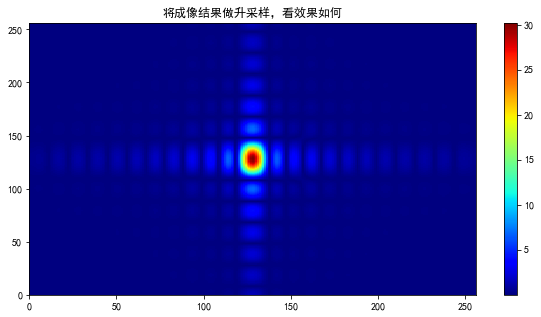

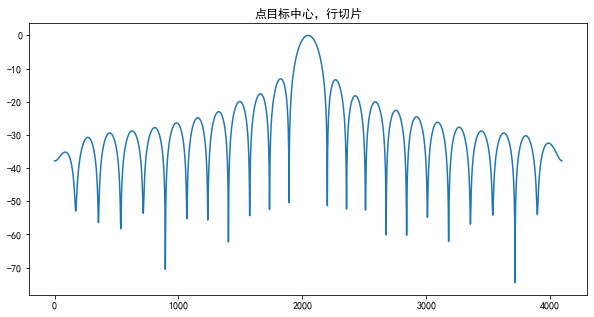

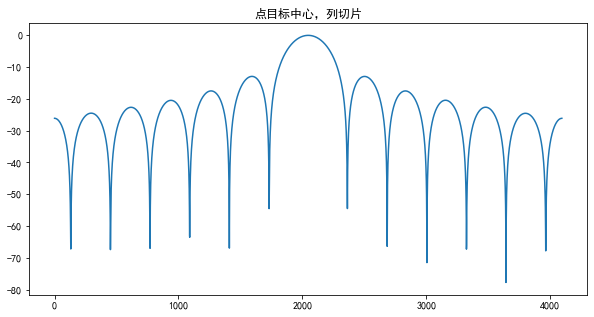

In [14]:
##
# 下面通过调用函数，得到三个点目标各自的切片，并进行升采样
# 同时对点目标中心做距离向切片，方位向切片
# 计算出相应的指标：PSLR，ISLR，IRW

NN = 16;
# 分别得到每个点目标的切片放大；行切片、列切片；和相应的指标
# 目标1，点目标中心在 （（Naz/2+1），86）
Nst = int(Naz/2+1)

# print(tgt.shape)
# print( Nst-NN,Nst+NN )
# print( 86-NN,86+NN )
# print(  s_ac[Nst- NN:Nst+NN,86-NN:86+NN] )
target_1 = target_analysis( s_ac[Nst-NN-1:Nst+NN,86-NN-1:86+NN],Fr,Fa,Vr);

# 目标2，点目标中心在 （（Naz/2+1+delta_R1/Vr*Fa）,86）
# tg_2_delatx = int(Naz/2+1 + delta_R1/Vr*Fa);
# print( tg_2_delatx )
# target_2 = target_analysis( s_ac[tg_2_delatx-NN-1:tg_2_delatx+NN,86-NN-1:86+NN],Fr,Fa,Vr);

# # 目标3
# tg_3_delatx = int(tg_2_delatx + delta_R2*tan(sita_r_c)/Vr*Fa);
# tg_3_delaty = int(2*delta_R2/c*Fr);
# target_3 = target_analysis( s_ac[tg_3_delatx-NN:tg_3_delatx+NN,86+tg_3_delaty-NN:86+tg_3_delaty+NN],Fr,Fa,Vr);

本文Python代码参照Matlab代码自： https://github.com/denkywu/SAR-Synthetic-Aperture-Radar